# Closest Capital Analysis 

In [87]:
import pandas as pd
from simpledbf import Dbf5 as db
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 6]

### Reading dbf,converting, adding STATE column and creating DF with state capitals

In [88]:
dbf = db("distances_brasil.dbf")
distance_cities = dbf.to_dataframe()
distance_cities = distance_cities.drop(["codmun1"],axis=1)
distance_cities.at[distance_cities[distance_cities["NAME"]=="São Francisco de Assis do Piauí/P"].index[0],
          "NAME"] = "São Francisco de Assis do Piauí/PI"
distance_cities.at[distance_cities[distance_cities["NAME"]=="Vila Bela da Santíssima Trindade/M"].index[0],
          "NAME"] = "Vila Bela da Santíssima Trindade/MT"
distance_cities.at[distance_cities[distance_cities["NAME"]=="São Sebastião de Lagoa de Roça/P"].index[0],
          "NAME"] = "São Sebastião de Lagoa de Roça/PB"

In [89]:
distance_cities["STATE"] = [i.split("/")[-1] for i in distance_cities["NAME"]]
distance_cities

,NAME,NEAR_FID,NEAR_DIST,STATE
0,Aracaju/SE,1,1.279808e-10,SE
1,Belém/PA,2,1.580439e-10,PA
2,Belo Horizonte/MG,3,5.696375e-10,MG
3,Boa Vista/RR,4,3.281908e-10,RR
4,Brasília/DF,5,4.157356e-10,DF
...,...,...,...,...
5555,Xique-Xique/BA,23,4.735711e+00,BA
5556,Zabelê/PB,14,2.094263e+00,PB
5557,Zacarias/SP,25,4.229949e+00,SP
5558,Zé Doca/MA,24,1.679836e+00,MA


In [90]:
capitals = distance_cities[distance_cities.index < 27]

### Adding the column Closest Capital, with the closest capital to each brazilian city

In [91]:
distance_cities["Closest Capital"] = [capitals[capitals["NEAR_FID"] == i]["NAME"].to_numpy()[0]
                              for i in distance_cities["NEAR_FID"]]
distance_cities[60:70]

,NAME,NEAR_FID,NEAR_DIST,STATE,Closest Capital
60,Adrianópolis/PR,8,0.820954,PR,Curitiba/PR
61,Adustina/BA,1,1.095304,BA,Aracaju/SE
62,Afogados da Ingazeira/PE,14,2.700469,PE,Maceió/AL
63,Afonso Bezerra/RN,16,1.330577,RN,Natal/RN
64,Afonso Cláudio/ES,27,0.823306,ES,Vitória/ES
65,Afonso Cunha/MA,26,1.089236,MA,Teresina/PI
66,Afrânio/PE,26,3.868704,PE,Teresina/PI
67,Afuá/PA,13,0.706732,PA,Macapá/AP
68,Agrestina/PE,20,1.138124,PE,Recife/PE
69,Agricolândia/PI,26,0.722351,PI,Teresina/PI


### Grouping DF by state and Closest Capital and aggregating using size

In [92]:
grouped_states = distance_cities.groupby(["STATE","Closest Capital"]).agg("size").to_frame()
grouped_states = grouped_states.rename(columns={0: "Number"})
grouped_states = grouped_states.sort_values('Number', ascending=False).sort_index(level='STATE', sort_remaining=False)
grouped_states

Number
STATE Closest Capital          
AC    Rio Branco/AC          22
AL    Maceió/AL              73
      Aracaju/SE             29
AM    Manaus/AM              39
      Rio Branco/AC          13
...                         ...
SP    Rio de Janeiro/RJ       9
      Belo Horizonte/MG       1
TO    Palmas/TO             124
      Belém/PA               12
      Brasília/DF             3

[83 rows x 1 columns]

### Getting the number of cities closer to each capital

In [93]:
close_sum = pd.Series({i:grouped_states.xs(i,level=1).sum().to_numpy()[0] for i in capitals["NAME"]})
close_sum_sorted = close_sum.sort_values(ascending=False)
close_sum_sorted.head(10)

Porto Alegre/RS      585
Curitiba/PR          489
São Paulo/SP         486
Belo Horizonte/MG    461
Salvador/BA          344
Teresina/PI          319
Goiânia/GO           296
Campo Grande/MS      247
Fortaleza/CE         224
Palmas/TO            207
dtype: int64

### Getting the number of cities within the state which are closer to its capital

In [94]:
state_cities = pd.Series({j:grouped_states.loc[i,j].to_numpy()[0] for i,j in zip(capitals["STATE"],capitals["NAME"])})
state_cities_sorted = state_cities.sort_values(ascending=False)
state_cities_sorted.head(10)

Porto Alegre/RS      497
Belo Horizonte/MG    460
São Paulo/SP         385
Salvador/BA          325
Curitiba/PR          306
Teresina/PI          205
Goiânia/GO           179
Fortaleza/CE         156
Florianópolis/SC     136
Palmas/TO            124
dtype: int64

### Getting the number of cities per state

In [95]:
number_of_cities = pd.Series({i:grouped_states.xs(i).sum().to_numpy()[0] for i in capitals["STATE"]})
number_of_cities_sorted = number_of_cities.sort_values(ascending=False)
number_of_cities_sorted.head(10)

MG    853
SP    645
RS    497
BA    417
PR    399
SC    293
GO    246
PB    223
PI    222
MA    217
dtype: int64

### Ploting the percent of state cities within the capital's influence zone

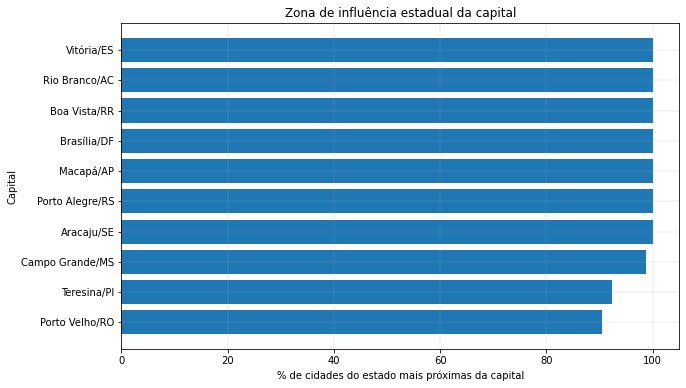

In [96]:
state_capitals = capitals["NAME"].unique()
percent_of_cities = pd.Series({state_capitals[i]:(state_cities[i]/number_of_cities[i])*100 for i in range(27)})
percent_of_cities = percent_of_cities.sort_values(ascending=True).tail(10)
plt.barh(percent_of_cities.index,percent_of_cities.values)
plt.title("Zona de influência estadual da capital")
plt.xlabel('% de cidades do estado mais próximas da capital')
plt.ylabel('Capital')
plt.grid(lw="0.2")
plt.show()

### Ploting the percent of all cities within the capital's influence zone

5560


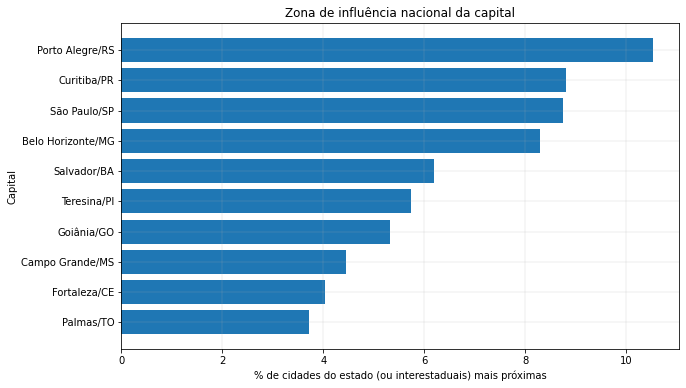

In [97]:
print(number_of_cities.sum())
percent_of_cities_national = pd.Series({state_capitals[i]:(close_sum[i]/number_of_cities.sum())*100 for i in range(27)})
percent_of_cities_national = percent_of_cities_national.sort_values(ascending=True).tail(10)
plt.barh(percent_of_cities_national.index,percent_of_cities_national.values)
plt.title("Zona de influência nacional da capital")
plt.xlabel('% de cidades do estado (ou interestaduais) mais próximas')
plt.ylabel('Capital')
plt.grid(lw="0.2")
plt.show()